### Aim: Use an RNN-based classifier to predict the sentiment of an IMDB movie reviews 

### Followed tutorial from:   https://www.kaggle.com/code/rafaeltiedra/step-by-step-imdb-sentiment-analysis


In [43]:
## import libraries
import pandas as pd
import livelossplot
import keras
from keras import Sequential, datasets
import matplotlib.pyplot as plt

import re
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

In [4]:
## read data
imdb = pd.read_csv("IMDB Dataset.csv")
imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [11]:
# Exploratory data analysis
print(imdb.describe())

# Sentiment count
print("\n\n Sentiment count: \n", imdb['sentiment'].value_counts())


                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


 Sentiment count: 
 positive    25000
negative    25000
Name: sentiment, dtype: int64


In [27]:
## data preprocessing
# transformations: remove punctuation marks,  HTML tags, URLs,  characters which are not letters or digits
# remove successive whitespaces, convert the text to lower case, strip whitespaces from the beginning and the end of the reviews
df = imdb
idx = random.randint(0, len(df)-1)
before_process = df.iloc[idx][0]

def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

df['review'] = df['review'].apply(lambda x: process(x))
after_process = df.iloc[idx][0]
after_process

'deaf secretary carla emmanuelle devos is bullied by her mean spirited male colleagues when they suggest she needs an assistant it seems like the final insult but when the first applicant is ex con paul vincent cassel she seizes the chance to change her life carla covers his mistakes and he anxious to go straight reluctantly helps her to take revenge on her colleagues when paul asks carla to return the favor she finds herself drawn into the criminal underworld ruled by ruthless lone shark marchand olivier gourmet recognizing her ability to lip read as a weapon no one will have bargained for the two set out to see justice done french filmmaker jacques audiard s third feature read my lips is a genre defying piece switching from dark social comedy to visceral full throttle thriller'

In [30]:
# remove stopwords from the reviews

nltk.download('stopwords')
nltk.download('punkt')
sw_set = set(nltk.corpus.stopwords.words('english'))

def sw_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in sw_set]
    return ' '.join(filtered_list)

df['review'] = df['review'].apply(lambda x: sw_remove(x))
after_removal = sw_remove(after_process)
after_removal


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kirannarta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kirannarta/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'deaf secretary carla emmanuelle devos bullied mean spirited male colleagues suggest needs assistant seems like final insult first applicant ex con paul vincent cassel seizes chance change life carla covers mistakes anxious go straight reluctantly helps take revenge colleagues paul asks carla return favor finds drawn criminal underworld ruled ruthless lone shark marchand olivier gourmet recognizing ability lip read weapon one bargained two set see justice done french filmmaker jacques audiard third feature read lips genre defying piece switching dark social comedy visceral full throttle thriller'

In [36]:
### Data split
train_rev, test_rev, train_sent, test_sent = train_test_split(df['review'], df['sentiment'], test_size=0.1, random_state=42)

print('train_rev.shape:', train_rev.shape)
print('test_rev.shape:', test_rev.shape)
print('train_sent.shape:' , train_sent.shape)
print('test_sent.shape:' , test_sent.shape)

train_rev.shape: (45000,)
test_rev.shape: (5000,)
train_sent.shape: (45000,)
test_sent.shape: (5000,)


In [37]:
### Data splitting and tokenization
# encode sentiment
df.sentiment = [1 if s == 'positive' else 0 for s in df.sentiment]

dict_size = 35000
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(df['review'])

print('\033[1m' + 'Dictionary size:' + '\033[0m', dict_size)
print('\033[1m' + 'Length of the tokenizer index:' + '\033[0m', len(tokenizer.word_index))
print('\033[1m' + 'Number of documents the tokenizer was trained on:' + '\033[0m', tokenizer.document_count, '\n')
print('\033[1m' + 'First 20 entries of the tokenizer index:' + '\033[0m')
print(*list(tokenizer.word_index.items())[:20])


Dictionary size: 35000
Length of the tokenizer index: 125791
Number of documents the tokenizer was trained on: 50000 

First 20 entries of the tokenizer index:
('movie', 1) ('film', 2) ('one', 3) ('like', 4) ('good', 5) ('time', 6) ('even', 7) ('would', 8) ('really', 9) ('story', 10) ('see', 11) ('well', 12) ('much', 13) ('get', 14) ('bad', 15) ('people', 16) ('great', 17) ('also', 18) ('first', 19) ('made', 20)


In [46]:
# use Tokenizer class to convert the training reviews and test reviews 
train_rev_tokens = tokenizer.texts_to_sequences(train_rev)
test_rev_tokens = tokenizer.texts_to_sequences(test_rev)
seq_lengths =  np.array([len(sequence) for sequence in train_rev_tokens])

# Storing in "upper_bound" our chosen upper bound for the length of sequences
# Computing the percentage of lengths smaller or equal than "upper_bound"

upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)

upper_bound

291

In [42]:
### Pad sequences
train_rev_pad = pad_sequences(train_rev_tokens, maxlen=upper_bound)
test_rev_pad = pad_sequences(test_rev_tokens, maxlen=upper_bound)

print('train_rev_pad.shape:', train_rev_pad.shape)
print('test_rev_pad.shape:', test_rev_pad.shape, '\n')

idx_pad = random.randint(0, len(train_rev_pad)-1)
idx_pad

train_rev_pad.shape: (45000, 291)
test_rev_pad.shape: (5000, 291) 



12549

In [68]:
idx_pad = random.randint(0, len(train_rev_pad)-1)
print('\033[1m' + 'Review #%d after padding:' %idx_pad + '\033[0m' + '\n', train_rev_pad[idx_pad])

Review #23694 after padding:
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0   916  3484   881  2996  1286 11572
 17774   162    36   691   658  1373   325   360    41  1681  1154 13317
    97  1481  3038   343 25765  3402  4348 27271   655   377  2245   669
     1  1630  2232  2

In [48]:
### Model 

model = Sequential()
model.add(Embedding(input_dim=dict_size, output_dim=14, input_length=291))
model.add(LSTM(16))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 291, 14)           490000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                1984      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 492,001
Trainable params: 492,001
Non-trainable params: 0
_________________________________________________________________


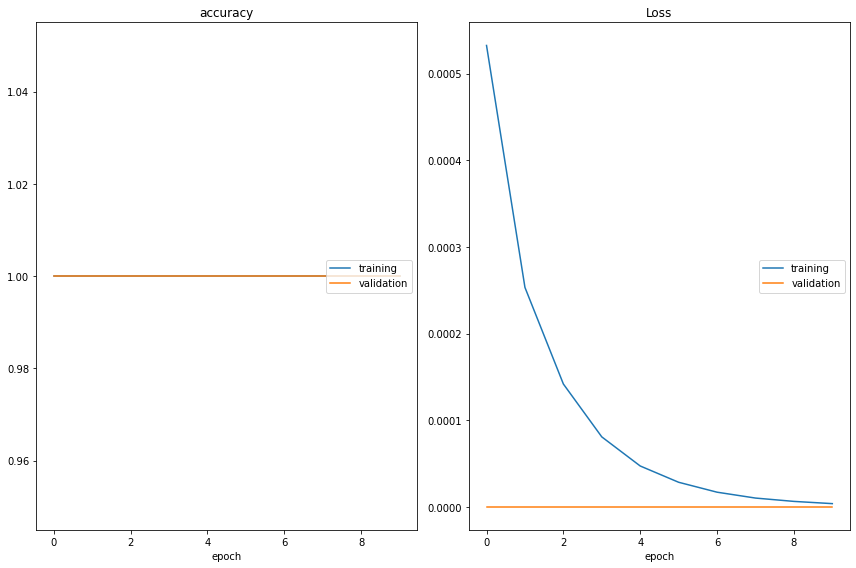

accuracy
	training         	 (min:    1.000, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


In [56]:
model.compile(optimizer='adam', loss='bce', metrics='accuracy')

from livelossplot import PlotLossesKeras

model.fit(train_rev_pad, train_sent,
          epochs=10, batch_size=32,
          validation_data=(test_rev_pad, test_sent),
          callbacks=[PlotLossesKeras()],
          verbose=0)

#model.fit(train_rev_pad, train_sent, validation_split=0.1,
#           epochs=5, batch_size=32,
#           validation_data=(test_rev_pad, test_sent),
#           callbacks=[PlotLossesKeras()],
#           verbose=0)

157/157 [==============================] - 2s 13ms/step - loss: 1.1047e-18 - accuracy: 1.0000
[1.1046784081637952e-18, 1.0]
[[5000]]


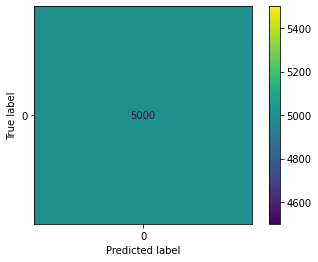

In [69]:
result= model.evaluate(test_rev_pad, test_sent)
print(result)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, f1_score

predictions = np.round(model.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_sent, predictions)
print(cf_matrix)
cm=confusion_matrix(test_sent, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


Conclusion: 

In this model I am getting an accuracy of 1. [I think there is an error would be getting back to this]